# Validation and Experiment

The influence functions are the asymptotic approximations of the leave-one-out retraining under the assumptions that (i) the model parameters $\hat{\beta}$ is the minimizer of the empirical risk, and (ii) the empirical risk is twice-differentiable and strictly convex (Koh 4). 

In this section, we will demonstrate that influence functions accurately approximate the LOO retraining process with all those assumptions satisfied. We also implement the Conjugate gradients(CG) technique to efficiently calculate the influence and compare its result with the close-formed influence and LOO. We will also show that the influence function can provide useful information even when some of the assumptions are violated.

## 1. Ridge Regression on Forest Fire dataset

Influence function assumes that the weight on a training point is changed by an infinitesimally small $\epsilon$. We investigate the relationship between the influence loss and the true LOO loss by comparing $-\frac{1}{n}\mathcal{I}_{loss}({z_{tr}}, {z_{te}})$ and $L(z_{te},\hat{\beta}_{-z_{tr}}) - L(z_{te},\hat{\beta})$ (i.e the actual LOO retraining loss). As mentioned in the introduction, we will calculate the influence loss in two ways, numerical (brutal force?????) and Conjugate gradients(CG).

The data we used is the [Forest Fires Data Set](http://archive.ics.uci.edu/ml/datasets/Forest+Fires) from UCI machine learning repository with 514 training points and 3 testing points. We trained this model using a $L_2$ regularization of 1.0

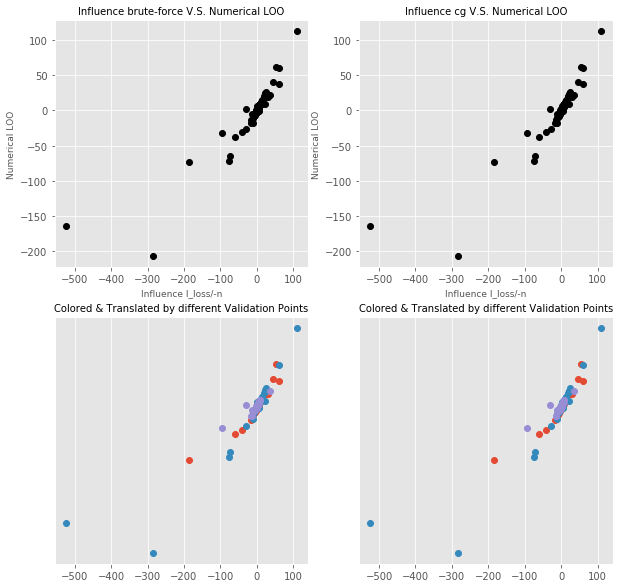

In [64]:
_ = compare_with_loo(
    [I_loss_bf[leave_indices,:], 
     I_loss_cg[leave_indices,:]], loo_diff, n_samples=n_tr)
plt.savefig('Ridge Regression on Forest Fire dataset Plots.eps', format='eps', dpi=1000)

We randomly selected 150 training point and 3 testing point as the demonstration. We see the approximation and actual changes matched closely. In fact, apart from two outliers, the approximation match the true LOO exactly. We can also observe that the influence loss calculated numerically (fig left) produce the same result as the influence loss calculated using CG.

The correlations between the Influence loss and actual LOO are 0.9215, 0.8930, and 0.8603 respectively. The overall correlation is 0.8946

## 2.1  Binary Logistic Regression on Iris Dataset

Applying the similar logic to the classification case, we will demonstrate the relationship between the influence loss and the true LOO loss in the Logistic regression models. We start with the binary logistic regression on the [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/Iris), with 80 training points and 40 testing points.

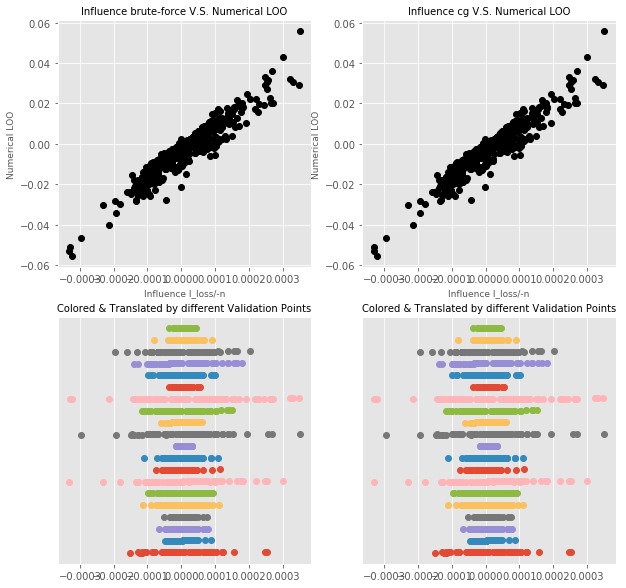

In [70]:
fig, axes = compare_with_loo(
    [I_loss_bf[:,:],
     I_loss_cg[:,:]],
    loo_diff, n_samples=n_tr
)
plt.savefig('Logistic Iris Plots.eps', format='eps', dpi=1000)

The influence loss demonstrates a strong linear correlation with the actual LOO loss in the binary logistic regression example with the Iris dataset. The overall correlation achieves 0.9345. Again, the Influence loss calculated numerically is same as the CG result. 

## 2.2 Binary Logistic Regression on MNIST Dataset

The influence loss is proved to be an accurate approximation to the LOO loss in the simple classification case. Now, we extend it to a more complicated scenario. This time we will use binary logistic regression model on the binary [MNIST](http://yann.lecun.com/exdb/mnist/) (Predict digit labels 1 and 4). The MNSIT data has much more features than the Iris dataset. We use 9075 training points, each of which has 784 features. We randomly pick 10 test points as a demonstration.


(*Add some modification you made for this case and the difficulies you overcomed especially the numerical part and manipulation of parameters?*)

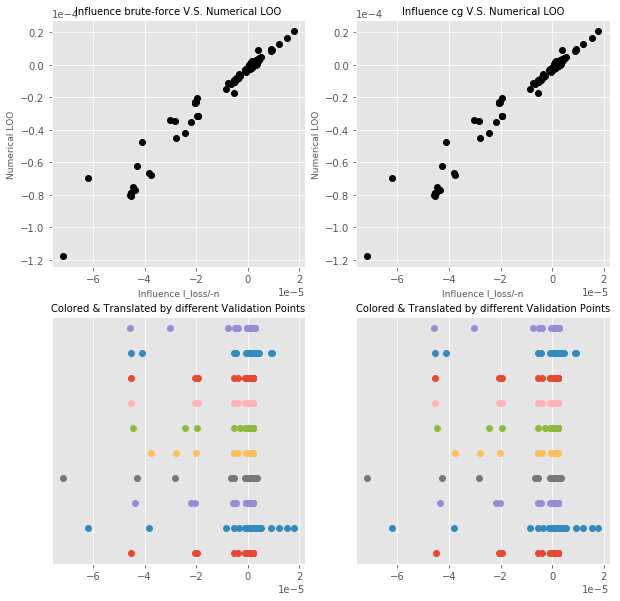

In [62]:
fig, axes = compare_with_loo(
    [I_loss_bf[leave_indices,:],
     I_loss_cg[leave_indices,:]],
    loo_diff, n_samples=n_tr
)
plt.savefig('Logistic MNIST Plots.eps', format='eps', dpi=1000)

The Influence loss and the actual LOO loss again demostrate a strong linear relation with an overall correlation: of 0.9829.

## 2.3 Multiclass Logistic Regression

We further extend the experiment to the multi-class classification case. We will use the logistic regression with the softmax decision function to apply on the [Full MNIST](http://yann.lecun.com/exdb/mnist/) dataset. In this case, we will have 41990 training points, each of which has 784 features. We randomly pick 10 test points as a demonstration.

*(Add if there are any further improvements!!!!)*

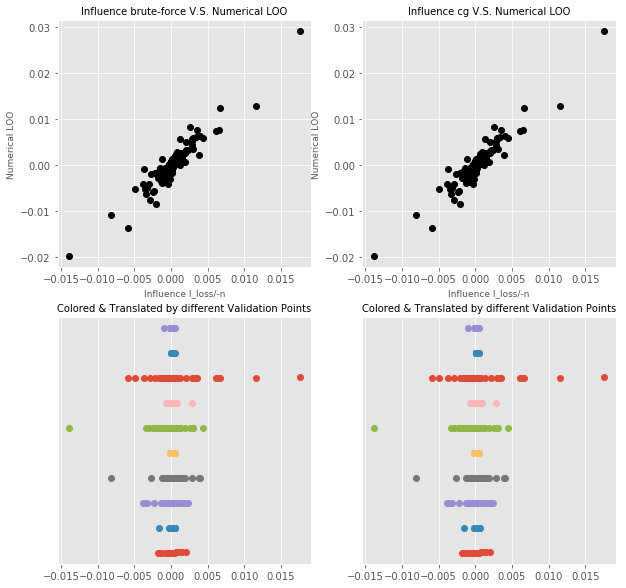

In [16]:
fig, axes = compare_with_loo(
    [I_loss_bf[leave_indices,:],
     I_loss_bf[leave_indices,:]],
    loo_diff, n_samples=n_tr
)
plt.savefig('Logistic Multiclass MNIST Plots.eps', format='eps', dpi=1000)

The multiclass MNIST case is also proved to be accurate. The overall correlation is 0.9429.

# -----------------------------Testing Code------------------------------------

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from data import Datafile, load_data
from influence.emp_risk_optimizer import EmpiricalRiskOptimizer
from influence.plot_utils import compare_with_loo
from models.regularized_regression import RegularizedRegression

from influence.closed_forms import I_loss_RidgeCf
from models.regularized_regression import RegularizedRegression
from models.hyperplane_clf import BinaryLogisticRegression

from models.hyperplane_clf import MulticlassLogisticRegression

## Code for ridge

In [4]:
%%capture
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.ForestFire, test_config=[2, 50, 187])
n_tr, p = X_train.shape
n_te, _ = X_test.shape
init_eta = 0.01
batch_size = 100
C = 1.0
train_iter = 50000
traceback_checkpoint = 50000
loo_extra_iter = 5000
decay_epochs = (5000, 8000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_to_sgd = np.inf
iter_to_switch_off_minibatch = 20000
np.random.seed(0)
leave_indices = np.random.choice(n_tr, size=150, replace=False)

In [5]:
%%capture
tf.reset_default_graph()
model = RegularizedRegression(
    model_name='RidgeRegression-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C
)
model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

In [6]:
%%capture
I_loss_bf = model.influence_loss(
    X_test, y_test,
    method='brute-force'
)
I_loss_cg = model.influence_loss(
    X_test, y_test,
    method='cg'
)
loo_diff = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices
)

INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999

INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999

In [13]:

def compare_with_loo(influences, loo_diff, n_samples,
                     method_names=('brute-force', 'cg')):
    n_methods = len(influences)
    fig, axes = plt.subplots(2, n_methods, figsize=(n_methods*5, 10))
    leave_tr, n_te = influences[0].shape
    for m in range(n_methods):
        for j in range(n_te):
            axes[0, m].plot(
                influences[m][:, j]/n_samples,
                loo_diff[:, j], 'o', color='black')
            axes[1, m].plot(
                influences[m][:, j]/n_samples,
                loo_diff[:, j] + j, 'o')

        axes[0, m].update({
            'title': 'Influence {} V.S. Numerical LOO'.format(method_names[m]),
            'xlabel': 'Influence I_loss/-n',
            'ylabel': 'Numerical LOO'
        })
        axes[0, m].title.set_fontsize(10)
        axes[0, m].xaxis.get_label().set_fontsize(9)
        axes[0, m].yaxis.get_label().set_fontsize(9)
        axes[0, m].ticklabel_format(style='sci',scilimits=(-3,4),axis='both') # Only for MNIST

        axes[1, m].update({
            'title': 'Colored & Translated by different Validation Points',
            'yticks': []})
        axes[1, m].title.set_fontsize(10)
        axes[1, m].xaxis.get_label().set_fontsize(9)
        axes[1, m].yaxis.get_label().set_fontsize(9)
        axes[1, m].ticklabel_format(style='sci',scilimits=(-3,4),axis='both') # Only for MNIST

    return fig, axes


## Code for Logistic

In [66]:
%%capture
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.Iris, test_config=0.2)
n_tr, p = X_train.shape
n_te, _ = X_test.shape
print(n_tr, p)

init_eta = 1e-1
batch_size = 30
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=35000
iter_to_switch_to_sgd=np.inf
# LOO a on random set of training indices, otherwise too slow
leave_indices = None

In [67]:
%%capture
model = BinaryLogisticRegression(
    model_name='BinaryLogistic-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=1.0
)
tf.reset_default_graph()
model = BinaryLogisticRegression(
    model_name='BinaryLogistic-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=1.0
)

model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)
tf.reset_default_graph()
model.fit_with_sklearn({'X':X_train, 'y':y_train})
model.get_eval(items=['params_flat'])
I_loss_bf = model.influence_loss(
    X_test, y_test,
    method='brute-force',
)
I_loss_cg = model.influence_loss(
    X_test, y_test,
    method='cg',
    tol=1e-7, 
    max_iter=1000
)
loo_diff = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
    sklearn_refit=True
)

## ----------MNIST---------------

In [40]:
%%capture
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.BinaryMNIST17, test_config=10)
n_tr, p = X_train.shape
n_te, _ = X_test.shape
print(n_tr, p)

init_eta = 1e-1
batch_size = 30
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=35000
iter_to_switch_to_sgd=np.inf
# LOO a on random set of training indices, otherwise too slow
leave_indices = np.random.choice(n_tr, size=150, replace=False)

In [42]:
%%capture
model = BinaryLogisticRegression(
    model_name='BinaryLogistic-MNIST',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=1000000.0
)

In [43]:
tf.reset_default_graph()
model.fit_with_sklearn({'X':X_train, 'y':y_train})


Model Evaluations:
------------------------------------------
Empirical Risk: 0.041259
Norm of Params: 0.014537
Norm of Gradient: 1.601866


BinaryLogistic-MNIST(init_eta=0.1,batch_size=30,decay_epochs=(10000, 20000),C=1000000.0)

In [44]:
y_pred = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [45]:
I_loss_bf = model.influence_loss(
    X_test, y_test,
    method='brute-force',
    damping = 0.01
)

Fetch training loss gradients (4.412 sec)


In [47]:
I_loss_cg = model.influence_loss(
    X_test, y_test,
    method='cg',
    tol=1e-7, 
    max_iter=1000,
    damping = 0.01
)

Fetch training loss gradients (4.426 sec)
CG Objective: 676.47
CG Objective: 116.27133
CG Objective: 26.676876
CG Objective: 0.6393983
CG Objective: 0.043813758
CG Objective: 0.003689263
CG Objective: -0.008687841
CG Objective: -0.009648381
CG Objective: -0.009844104
CG Objective: -0.009848632
CG Objective: -0.009849878
CG Objective: -0.009849962
CG Objective: -0.009849964
Optimization terminated successfully.
         Current function value: -0.009850
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 26
         Hessian evaluations: 44
CG Objective: 17985.111
CG Objective: 3379.7742
CG Objective: 396.16235
CG Objective: 34.840103
CG Objective: 7.2132998
CG Objective: 1.6677014
CG Objective: 0.3817429
CG Objective: 0.07413123
CG Objective: -0.019176848
CG Objective: -0.028613023
CG Objective: -0.031820793
CG Objective: -0.03191781
CG Objective: -0.03193147
CG Objective: -0.03193238
CG Objective: -0.03193268
CG Objective: -0.031932697
Optimization 

In [48]:
loo_diff = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
    sklearn_refit=True
)

LOO Fold 0: loss = 0.04126145 (0.158 sec)
LOO Fold 15: loss = 0.04126092 (0.086 sec)
LOO Fold 30: loss = 0.04126136 (0.087 sec)
LOO Fold 45: loss = 0.04126123 (0.072 sec)
LOO Fold 60: loss = 0.04125781 (0.107 sec)
LOO Fold 75: loss = 0.04126132 (0.093 sec)
LOO Fold 90: loss = 0.04126137 (0.071 sec)
LOO Fold 105: loss = 0.04126124 (0.104 sec)
LOO Fold 120: loss = 0.04126099 (0.093 sec)
LOO Fold 135: loss = 0.04126146 (0.166 sec)


In [49]:
# leave_indices case
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_bf[leave_indices, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_bf[leave_indices, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.9873
Test Point 1 Correlation: 0.9759
Test Point 2 Correlation: 0.9866
Test Point 3 Correlation: 0.9944
Test Point 4 Correlation: 0.9861
Test Point 5 Correlation: 0.9878
Test Point 6 Correlation: 0.9874
Test Point 7 Correlation: 0.9874
Test Point 8 Correlation: 0.9759
Test Point 9 Correlation: 0.9806
Overall Correlation: 0.9829


## ----------Multi MNIST---------------

In [3]:
%%capture
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.FullMNIST, test_config=10)
n_tr, p = X_train.shape
n_te, _ = X_test.shape

In [4]:
%%capture
subsample = np.random.choice(n_tr, size=5000, replace=False)
X_train = X_train[subsample,:]
y_train = y_train[subsample,:]
y_train_onehot = np.eye(10)[y_train.reshape(-1)]
y_test_onehot = np.eye(10)[y_test.reshape(-1)]
n_tr, p = X_train.shape
n_te, _ = X_test.shape

init_eta = 1e-1
batch_size = 30
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=35000
iter_to_switch_to_sgd=np.inf
# LOO a on random set of training indices, otherwise too slow
leave_indices = np.random.choice(n_tr, size=150, replace=False)

In [5]:
%%capture
model = MulticlassLogisticRegression(
    model_name='MultiClassLogistic-MNIST',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=1e7
)
tf.reset_default_graph()
model.fit_with_sklearn({'X':X_train, 'y':y_train_onehot})

In [6]:
I_loss_bf = model.influence_loss(
    X_test, y_test_onehot,
    method='brute-force',
)

Fetch training loss gradients (4.132 sec)


In [7]:
loo_diff = model.leave_one_out_refit(
    X_test, y_test_onehot,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
    sklearn_refit=True
)

LOO Fold 0: loss = 1.25705302 (0.306 sec)
LOO Fold 15: loss = 1.25698960 (0.475 sec)
LOO Fold 30: loss = 1.25691283 (0.228 sec)
LOO Fold 45: loss = 1.25697935 (0.350 sec)
LOO Fold 60: loss = 1.25717413 (0.341 sec)
LOO Fold 75: loss = 1.25690055 (0.437 sec)
LOO Fold 90: loss = 1.25714660 (0.360 sec)
LOO Fold 105: loss = 1.25672555 (0.321 sec)
LOO Fold 120: loss = 1.25702083 (0.693 sec)
LOO Fold 135: loss = 1.25709510 (0.385 sec)


In [15]:
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_bf[leave_indices, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_bf[leave_indices, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.8941
Test Point 1 Correlation: 0.8968
Test Point 2 Correlation: 0.9570
Test Point 3 Correlation: 0.9419
Test Point 4 Correlation: 0.9113
Test Point 5 Correlation: 0.9180
Test Point 6 Correlation: 0.9567
Test Point 7 Correlation: 0.9572
Test Point 8 Correlation: 0.9065
Test Point 9 Correlation: 0.8608
Overall Correlation: 0.9429
